**Homework 2:**
Top university rankings


# topuniversities.com section
Strategy for www.topuniversities.com website:
1. Analysis of web traffic after sending GET request shows that basic informations can be retrived just by getting json file from website.
2. We created DataFrame, from json, which contains basic information and urls to details page of every university.
3. Next step was to analyse detail page structure to obtain as much information as we can. This step make use of BeautifulSoup library.
4. In order to get details of each university we iterated through url and nid attributes of basic DataFrame and downloaded detail page together with json file (containing more information)
5. After downloading detail page we extracted details using BeautifulSoup and create DF. We did that with every university concatenating created DF.
6. At the end we merged (joined) both basic and details DF together on url attribute.
7. Cleaning the data was done in required places.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import difflib

In [2]:
# Get basic ranking using the same api as website does. Link comes from analysing web traffic after GET request to topunieversities.com website
top_universities_url = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508409283658'
r = requests.get(top_universities_url).json()


In [115]:
# Take only first 200 records and put them into DataFrame
top_unis = pd.DataFrame.from_dict(r['data'][:200])
top_unis = top_unis[['rank_display', 'title', 'country', 
       'region', 'url', 'nid']]
print(top_unis)

    rank_display                                              title  \
0              1        Massachusetts Institute of Technology (MIT)   
1              2                                Stanford University   
2              3                                 Harvard University   
3              4       California Institute of Technology (Caltech)   
4              5                            University of Cambridge   
5              6                               University of Oxford   
6              7                    UCL (University College London)   
7              8                            Imperial College London   
8              9                              University of Chicago   
9             10  ETH Zurich - Swiss Federal Institute of Techno...   
10            11  Nanyang Technological University, Singapore (NTU)   
11            12    Ecole Polytechnique Fédérale de Lausanne (EPFL)   
12            13                               Princeton University   
13    

In [116]:
#Create a table with all the details that can be found on a university website 


details = pd.DataFrame()
for url, nid in zip(top_unis['url'].values, top_unis['nid'].values):
    #print(url)

    req = requests.get('https://www.topuniversities.com' + url)
    soup = BeautifulSoup(req.text, 'html.parser')
    req2 = requests.get('https://www.topuniversities.com/qs-profiles/classifications/' + nid).json()

    d = dict()
    d['url'] = url
    try:
        d['Total faculty members'] = int(soup.find("div", class_="total faculty").find("div", class_="number").string.strip().replace(",", ""))
        d['International faculty members'] = int(soup.find("div", class_="inter faculty").find("div", class_="number").string.strip().replace(",", ""))
        d['Total number of students'] = int(soup.find("div", class_="total student").find("div", class_="number").string.strip().replace(",", ""))
        d['Total international students'] = int(soup.find("div", class_="total inter").find("div", class_="number").string.strip().replace(",", ""))
        d['Postgraduate students [%]'] = int(soup.find("div", class_="total student").find("div", class_="post").span.string.strip().replace("%", ""))
        d['Undergraduate students [%]'] = int(soup.find("div", class_="total student").find("div", class_="grad").span.string.strip().replace("%", ""))
        d['Postgraduate international students [%]'] = int(soup.find("div", class_="total inter").find("div", class_="post").span.string.strip().replace("%", ""))
        d['Undergraduate international students [%]'] = int(soup.find("div", class_="total inter").find("div", class_="grad").span.string.strip().replace("%", ""))

        #for s in soup.find("ul", class_="score").strings:
        #    print(s)

        #soup.find("div", id="wurc").find("ul", class_="score")

        score_type = [elem.string.strip() for elem in soup.find("ul", class_="score").find_all("div", class_="criteria")]
        score_value = [float(elem.string) for elem in soup.find("ul", class_="score").find_all("div", class_="text")]
        lis = list(zip(score_type, score_value))

        d.update(dict((type_, value_) for type_, value_ in lis))
        d.update(req2['classifications'])
        #temp = soup.find("ul", id = "uni-info").find_all("h4")

        #d['Age'] = temp[1].span.string
        #d['Status'] = temp[2].span.string
        #d['Research'] = temp[3].span.string
        #d['Focus'] = temp[4].span.string
        #for element in temp:
        #   d[element.contents[0].strip()] = element.span.string.strip()
    except:
        pass
    details = pd.concat([details, pd.DataFrame.from_dict([d])], ignore_index=True)
    
details.head()

,Academic Reputation,Citations per Faculty,Employer Reputation,Faculty Student,International Faculty,International Students,International faculty members,Overall Score,Postgraduate international students [%],Postgraduate students [%],...,Total international students,Total number of students,Undergraduate international students [%],Undergraduate students [%],age_value,data_status_value,research_intensity_value,size_value,subject_range_value,url
0,100.0,99.9,100.0,100.0,100.0,96.1,1679.0,100.0,83.0,60.0,...,3717.0,11067.0,17.0,40.0,5,B,VH,M,CO,/universities/massachusetts-institute-technolo...
1,100.0,99.4,100.0,100.0,99.6,72.7,2042.0,98.7,83.0,56.0,...,3611.0,15878.0,17.0,44.0,5,B,VH,L,FC,/universities/stanford-university
2,100.0,99.9,100.0,98.3,96.5,75.2,1311.0,98.4,85.0,69.0,...,5266.0,22429.0,15.0,31.0,5,B,VH,L,FC,/universities/harvard-university
3,99.5,100.0,85.4,100.0,93.4,89.2,350.0,97.7,87.0,56.0,...,647.0,2255.0,13.0,44.0,5,B,VH,S,CO,/universities/california-institute-technology-...
4,100.0,78.3,100.0,100.0,97.4,97.7,2278.0,95.6,64.0,37.0,...,6699.0,18770.0,36.0,63.0,5,A,VH,L,FC,/universities/university-cambridge


In [117]:
# Merge of two DF on url column
Total = top_unis.merge(details, left_on='url', right_on='url', how='outer')
# Rename rank column and getting rid of "=" sign in rank column
Total.rename(columns={'rank_display': 'Rank TU'}, inplace=True)
Total['Rank TU'] = Total['Rank TU'].str.replace("=", "")

#Renaming the columns

Total.rename(columns={'Rank TU': 'Ranking', 'title': 'University', 'country':'Country', 'region': 'Region'}, inplace=True)
Total

,Ranking,University,Country,Region,url,nid,Academic Reputation,Citations per Faculty,Employer Reputation,Faculty Student,...,Total faculty members,Total international students,Total number of students,Undergraduate international students [%],Undergraduate students [%],age_value,data_status_value,research_intensity_value,size_value,subject_range_value
0,1,Massachusetts Institute of Technology (MIT),United States,North America,/universities/massachusetts-institute-technolo...,294850,100.0,99.9,100.0,100.0,...,2982.0,3717.0,11067.0,17.0,40.0,5,B,VH,M,CO
1,2,Stanford University,United States,North America,/universities/stanford-university,297282,100.0,99.4,100.0,100.0,...,4285.0,3611.0,15878.0,17.0,44.0,5,B,VH,L,FC
2,3,Harvard University,United States,North America,/universities/harvard-university,294270,100.0,99.9,100.0,98.3,...,4350.0,5266.0,22429.0,15.0,31.0,5,B,VH,L,FC
3,4,California Institute of Technology (Caltech),United States,North America,/universities/california-institute-technology-...,294562,99.5,100.0,85.4,100.0,...,953.0,647.0,2255.0,13.0,44.0,5,B,VH,S,CO
4,5,University of Cambridge,United Kingdom,Europe,/universities/university-cambridge,294561,100.0,78.3,100.0,100.0,...,5490.0,6699.0,18770.0,36.0,63.0,5,A,VH,L,FC
5,6,University of Oxford,United Kingdom,Europe,/universities/university-oxford,294654,100.0,76.3,100.0,100.0,...,6750.0,7353.0,19720.0,26.0,56.0,5,A,VH,L,FC
6,7,UCL (University College London),United Kingdom,Europe,/universities/ucl-university-college-london,294014,99.7,74.7,99.5,99.1,...,6345.0,14854.0,31080.0,45.0,52.0,5,A,VH,XL,FC
7,8,Imperial College London,United Kingdom,Europe,/universities/imperial-college-london,294030,99.4,68.7,100.0,100.0,...,3930.0,8746.0,16090.0,47.0,57.0,5,A,VH,L,FC
8,9,University of Chicago,United States,North America,/universities/university-chicago,294536,99.9,85.9,92.9,96.5,...,2449.0,3379.0,13557.0,24.0,43.0,5,B,VH,L,FC
9,10,ETH Zurich - Swiss Federal Institute of Techno...,Switzerland,Europe,/universities/eth-zurich-swiss-federal-institu...,294432,99.6,98.7,99.4,68.2,...,2477.0,7563.0,19815.0,28.0,47.0,5,A,VH,L,CO


In [118]:
#Create a table with only the data we will use for the analysis 

Analysis_df=Total[['Ranking','University', 'Country', 'Region', 'Total number of students', 'Total international students', 'Total faculty members', 'International faculty members']]
Analysis_df

,Ranking,University,Country,Region,Total number of students,Total international students,Total faculty members,International faculty members
0,1,Massachusetts Institute of Technology (MIT),United States,North America,11067.0,3717.0,2982.0,1679.0
1,2,Stanford University,United States,North America,15878.0,3611.0,4285.0,2042.0
2,3,Harvard University,United States,North America,22429.0,5266.0,4350.0,1311.0
3,4,California Institute of Technology (Caltech),United States,North America,2255.0,647.0,953.0,350.0
4,5,University of Cambridge,United Kingdom,Europe,18770.0,6699.0,5490.0,2278.0
5,6,University of Oxford,United Kingdom,Europe,19720.0,7353.0,6750.0,2964.0
6,7,UCL (University College London),United Kingdom,Europe,31080.0,14854.0,6345.0,2554.0
7,8,Imperial College London,United Kingdom,Europe,16090.0,8746.0,3930.0,2071.0
8,9,University of Chicago,United States,North America,13557.0,3379.0,2449.0,635.0
9,10,ETH Zurich - Swiss Federal Institute of Techno...,Switzerland,Europe,19815.0,7563.0,2477.0,1886.0


- Which are the best universities in term of (a) ratio between faculty members and students


In [130]:
#taking the interesting data and calculate the ratio 
FS_ratio_df = Analysis_df[['University','Country', 'Region','Total number of students','Total faculty members']]

#calculate the ratio of student per faculty member
FS_ratio_df['Ratio']= FS_ratio_df['Total number of students'] / FS_ratio_df['Total faculty members']

#calculate the ranking of each university considering that the less students per faculty members the better 
FS_ratio_df['Rank']=FS_ratio_df['Ratio'].rank()

#sort the results and print the 10 first universities
FS_ratio_df = FS_ratio_df.sort_values(['Rank'], ascending=[True])
FS_ratio_df.head(10)

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,University,Country,Region,Total number of students,Total faculty members,Ratio,Rank
3,California Institute of Technology (Caltech),United States,North America,2255.0,953.0,2.366212,1.0
15,Yale University,United States,North America,12402.0,4940.0,2.510526,2.0
5,University of Oxford,United Kingdom,Europe,19720.0,6750.0,2.921481,3.0
4,University of Cambridge,United Kingdom,Europe,18770.0,5490.0,3.418944,4.0
16,Johns Hopkins University,United States,North America,16146.0,4462.0,3.618557,5.0
1,Stanford University,United States,North America,15878.0,4285.0,3.705484,6.0
0,Massachusetts Institute of Technology (MIT),United States,North America,11067.0,2982.0,3.711268,7.0
185,University of Rochester,United States,North America,9636.0,2569.0,3.750876,8.0
18,University of Pennsylvania,United States,North America,20639.0,5499.0,3.753228,9.0
17,Columbia University,United States,North America,25045.0,6189.0,4.046696,10.0


Answer the previous question aggregating the data by (c) country and (d) region.

In [129]:
# (c) aggregating the data by country : we decide to take the mean of the ratios among universities in the same country and then rank over these ratios
FS_country_df=FS_ratio_df

FS_country_df['Country mean student/faculty ratio']= (FS_country_df.groupby(['Country'])['Ratio']
                              .transform('mean'))
FS_country_df=FS_country_df[['Country','Country mean student/faculty ratio']].drop_duplicates()


#calculate the ranking of each university considering that the less students per faculty members the better 
FS_country_df['Rank']=FS_country_df['Country mean student/faculty ratio'].rank()

#sort the results and print the 10 first countries
FS_country_df = FS_country_df.sort_values(['Rank'], ascending=[True])
FS_country_df.head(10)


,Country,Country mean student/faculty ratio,Rank
94,Russia,4.506335,1.0
172,Saudi Arabia,5.687382,2.0
10,Singapore,6.171431,3.0
113,Malaysia,6.498004,4.0
75,Japan,6.566145,5.0
116,Denmark,6.603256,6.0
70,South Korea,6.865503,7.0
144,Israel,7.350378,8.0
74,Argentina,7.447841,9.0
58,France,7.767984,10.0


In [123]:
# (d) aggregating the data by region 

FS_region_df=FS_ratio_df
FS_region_df['Region mean student/faculty ratio']= (FS_region_df.groupby(['Region'])['Ratio']
                              .transform('mean'))
FS_region_df=FS_region_df[['Region','Region mean student/faculty ratio']].drop_duplicates()


#calculate the ranking of each university considering that the less students per faculty members the better 
FS_region_df['Rank']=FS_region_df['Region mean student/faculty ratio'].rank()

#sort the results 
FS_region_df = FS_region_df.sort_values(['Rank'], ascending=[True])
FS_region_df


,Region,Region mean student/faculty ratio,Rank
70,Asia,7.933123,1.0
3,North America,9.214235,2.0
5,Europe,9.874120,3.0
197,Latin America,11.235437,4.0
190,Africa,11.305828,5.0
19,Oceania,13.794974,6.0


- Which are the best universities in term of (b) ratio of international students? 

In [132]:
#taking the interesting data and calculate the ratio 
IS_ratio_df = Analysis_df[['University','Country', 'Region','Total number of students','Total international students']]

#calculate the ratio of student per faculty member
IS_ratio_df['Ratio']= IS_ratio_df['Total international students'] / IS_ratio_df['Total number of students']

#calculate the ranking of each university considering that the more international students the better 
IS_ratio_df['Rank']=IS_ratio_df['Ratio'].rank(ascending=0)

#sort the results and print the 10 first universities
IS_ratio_df = IS_ratio_df.sort_values(['Rank'], ascending=[True])
IS_ratio_df.head(10)

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,University,Country,Region,Total number of students,Total international students,Ratio,Rank
34,London School of Economics and Political Scien...,United Kingdom,Europe,9760.0,6748.0,0.691393,1.0
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),Switzerland,Europe,10343.0,5896.0,0.570047,2.0
7,Imperial College London,United Kingdom,Europe,16090.0,8746.0,0.543567,3.0
198,Maastricht University,Netherlands,Europe,16385.0,8234.0,0.502533,4.0
47,Carnegie Mellon University,United States,North America,13356.0,6385.0,0.478062,5.0
6,UCL (University College London),United Kingdom,Europe,31080.0,14854.0,0.477928,6.0
91,University of St Andrews,United Kingdom,Europe,8800.0,4030.0,0.457955,7.0
41,The University of Melbourne,Australia,Oceania,42182.0,18030.0,0.427434,8.0
126,Queen Mary University of London,United Kingdom,Europe,16135.0,6806.0,0.421816,9.0
25,The University of Hong Kong,Hong Kong,Asia,20214.0,8230.0,0.407144,10.0


Answer the previous question aggregating the data by (c) country and (d) region.

In [133]:
# (c) aggregating the data by country : we decide to take the mean of the ratios among universities in the same country and then rank over these ratios
IS_country_df=IS_ratio_df
IS_country_df['Country mean international students ratio']= (IS_country_df.groupby(['Country'])['Ratio']
                              .transform('mean'))
IS_country_df=IS_country_df[['Country','Country mean international students ratio']].drop_duplicates()


#calculate the ranking of each university considering that the more international students the better 
IS_country_df['Rank']=IS_country_df['Country mean international students ratio'].rank(ascending=0)

#sort the results and print the 10 first countries
IS_country_df = IS_country_df.sort_values(['Rank'], ascending=[True])
IS_country_df.head(10)

,Country,Country mean international students ratio,Rank
34,United Kingdom,0.351308,1.0
41,Australia,0.346878,2.0
11,Switzerland,0.313816,3.0
25,Hong Kong,0.312148,4.0
153,Austria,0.306095,5.0
10,Singapore,0.277091,6.0
31,Canada,0.252604,7.0
81,New Zealand,0.248971,8.0
198,Netherlands,0.245456,9.0
87,Ireland,0.241791,10.0


In [149]:
# (d) aggregating the data by region 

IS_region_df=IS_ratio_df[0:-1]
IS_region_df['Region mean international students ratio']= (IS_region_df.groupby(['Region'])['Ratio']
                              .transform('mean'))
IS_region_df=IS_region_df[['Region','Region mean international students ratio']].drop_duplicates()


#calculate the ranking of each university considering that the more international students the better 
IS_region_df['Rank']=IS_region_df['Region mean international students ratio'].rank(ascending=0)

#sort the results 
IS_region_df = IS_region_df.sort_values(['Rank'], ascending=[True])
IS_region_df


C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Index(['Region', 'Region mean international students ratio', 'Rank'], dtype='object')

Plot your data using bar charts and describe briefly what you observed.

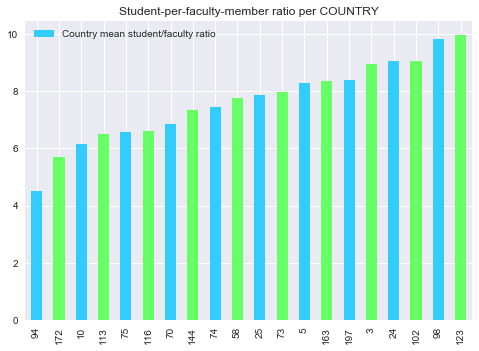

In [193]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

FS_country_df.head(20)[['Country mean student/faculty ratio']].plot.bar(title='Student-per-faculty-member ratio per COUNTRY', color=('#33ccff','#66ff66'))




#titanic_data.age.hist(bins=list(range(0,100,10)), rwidth=0.9)

#plt.title('Titanic \nAge distribution')
#plt.xlabel('Age (in decade)')
#plt.ylabel('Number of passengers')
#plt.xticks([0,10,20,30,40,50,60,70,80,90])

# timeshighereducation.com section
Strategy for www.timeshighereducation.com:
1. Similarly as in previous task we analysed web traffic (Postman app or Developer tools) after sending GET request and found an url to the json file with all needed informations. DataFrame was created using that json file.
2. Besides data cleaning and renaming or droping attributes, no futher actions were applied because of very handy json file structure.

In [6]:
times_rank_url = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
r = requests.get(times_rank_url).json()

In [7]:
top_unis_times = pd.DataFrame.from_dict(r['data'][:200])

In [8]:
top_unis_times['stats_number_students'] = top_unis_times.stats_number_students.str.replace(",", "")

In [9]:
top_unis_times.columns

Index(['aliases', 'location', 'member_level', 'name', 'nid', 'rank',
       'rank_order', 'record_type', 'scores_citations',
       'scores_citations_rank', 'scores_industry_income',
       'scores_industry_income_rank', 'scores_international_outlook',
       'scores_international_outlook_rank', 'scores_overall',
       'scores_overall_rank', 'scores_research', 'scores_research_rank',
       'scores_teaching', 'scores_teaching_rank', 'stats_female_male_ratio',
       'stats_number_students', 'stats_pc_intl_students',
       'stats_student_staff_ratio', 'subjects_offered', 'url'],
      dtype='object')

In [10]:
times_relevant_columns = ['rank', 'name', 'location',  
       'scores_citations', 'scores_citations_rank', 'scores_industry_income',
       'scores_industry_income_rank', 'scores_international_outlook',
       'scores_international_outlook_rank', 'scores_overall',
       'scores_overall_rank', 'scores_research', 'scores_research_rank',
       'scores_teaching', 'scores_teaching_rank', 'stats_female_male_ratio',
       'stats_number_students', 'stats_pc_intl_students',
       'stats_student_staff_ratio']

top_unis_times = top_unis_times[times_relevant_columns]

top_unis_times['rank'] = top_unis_times['rank'].str.replace("=", "").apply(pd.to_numeric)

# Merging both ranking DataFrames
Strategy:
1. We checked how many of university names overlap (105).
2. We looked at those which were not matched and found out that many of them have an abbreviation at the end, so we deleted them using regex to find every string that contains parentheses, for example '(MIT)' or '(EPFL)'.
3. After that operation there were 119 matched universities.
4. Another differentiating thing was the word `The` at the beginning of universities' names (139 matched).
5. At the end we used difflib library and its `get_close_matches` function iteratively with different cutoff parameter to find best matches between not matched names. That part required more manual assigning.
6. We ended up with 160 matched universities.
7. Merging was made on respectively `name` and `title` columns.

In [11]:
matching_names_total_in_times = np.array([title in top_unis_times['name'].values for title in Total['title'].values])
matching_names_total_in_times

array([False,  True,  True, False,  True,  True, False,  True,  True,
       False, False, False,  True,  True, False,  True,  True,  True,
        True, False,  True,  True, False, False,  True, False, False,
       False,  True, False,  True,  True, False, False, False,  True,
        True,  True, False,  True, False, False, False,  True, False,
       False, False,  True,  True, False,  True, False,  True,  True,
        True, False, False,  True, False,  True,  True,  True, False,
        True,  True, False,  True, False,  True,  True, False,  True,
        True,  True, False, False, False,  True,  True, False,  True,
       False, False,  True, False, False,  True, False,  True, False,
        True,  True, False,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False, False,  True,
        True,  True, False,  True,  True, False,  True, False,  True,
        True,  True, False, False, False, False, False, False,  True,
        True, False,

This names were not matched between `Total` and `top_unis_times`

In [12]:
not_matched = Total[~matching_names_total_in_times].title.values
print(len(not_matched))

95


In [13]:
Total.loc[Total['title'] == 'UCL (University College London)', 'title'] = 'University College London'
top_unis_times.loc[top_unis_times['name'] == 'ETH Zurich – Swiss Federal Institute of Technology Zurich'
                   , 'name'] = 'ETH Zurich - Swiss Federal Institute of Technology'
Total.loc[Total['title'] == 'Ecole Polytechnique Fédérale de Lausanne (EPFL)', 'title'] = 'École Polytechnique Fédérale de Lausanne'

In [14]:
for not_match in not_matched:
    Total.loc[Total['title'] == not_match, 'title'] = re.sub(r"\((.*?)\)", "" , not_match).strip()

In [15]:
matching_names_total_in_times_2 = np.array([title in top_unis_times['name'].values for title in Total['title'].values])
print(np.count_nonzero(matching_names_total_in_times_2))

119


Plenty of names differ only by a `The` at the beginning of a `name`

In [16]:
similar = [(elem, difflib.get_close_matches(elem, top_unis_times['name'].values, cutoff = 0.7)[0]) for elem in Total[~matching_names_total_in_times_2].title.values if difflib.get_close_matches(elem, top_unis_times['name'].values, cutoff = 0.7) != []]
len(similar)

55

In [17]:
for not_match in Total[~matching_names_total_in_times_2].title.values:
    Total.loc[Total['title'] == not_match, 'title'] = re.sub(r"^(The)\s", "" , not_match)

In [18]:
matching_names_total_in_times_3 = np.array([title in top_unis_times['name'].values for title in Total['title'].values])
print(np.count_nonzero(matching_names_total_in_times_3))

139


In [19]:
similar2 = [(elem, difflib.get_close_matches(elem, top_unis_times['name'].values, cutoff = 0.4)[0]) 
            for elem in Total[~matching_names_total_in_times_3].title.values 
            if difflib.get_close_matches(elem, top_unis_times['name'].values, cutoff = 0.4) != []]

In [20]:
names = [("King's College London", 'King’s College London'),
         ('KAIST - Korea Advanced Institute of Science & Technology',
          'Korea Advanced Institute of Science and Technology (KAIST)'),
         ('Ecole Polytechnique', 'École Polytechnique'),
         ('Pohang University of Science And Technology',
          'Pohang University of Science and Technology'),
         ('University of North Carolina, Chapel Hill',
          'University of North Carolina at Chapel Hill'),
         ('Washington University in St. Louis', 'Washington University in St Louis'),
         ('KIT, Karlsruhe Institute of Technology',
          'Karlsruhe Institute of Technology'),
         ('Humboldt-Universität zu Berlin', 'Humboldt University of Berlin'),
         ('Freie Universitaet Berlin', 'Free University of Berlin'),
         ('Université de Montréal', 'University of Montreal'),
         ('Technische Universität Berlin', 'Technical University of Berlin'),
         ('Université catholique de Louvain', 'Université Catholique de Louvain'),
         ('Trinity College Dublin, The University of Dublin',
          'Trinity College Dublin'),
         ("Scuola Superiore Sant'Anna Pisa di Studi Universitari e di Perfezionamento",
          'Scuola Superiore Sant’Anna'),
         ('Universitat Autònoma de Barcelona', 'Autonomous University of Barcelona'),
         ('Eberhard Karls Universität Tübingen', 'University of Tübingen')]
         
for total_name, top_unis_name in names:        
    Total.loc[Total['title'] == total_name, 'title'] = top_unis_name

In [21]:
matching_names_total_in_times_4 = np.array([title in top_unis_times['name'].values for title in Total['title'].values])
print(np.count_nonzero(matching_names_total_in_times_4))

155


In [22]:
matching_names_times_in_total = np.array([title in Total['title'].values for title in top_unis_times['name'].values])
print(np.count_nonzero(matching_names_times_in_total))

155


In [23]:
similar3 = [(elem, difflib.get_close_matches(elem, top_unis_times[~matching_names_times_in_total].name.values, cutoff = 0.2)) 
            for elem in Total[~matching_names_total_in_times_4].title.values]

In [24]:
names2 = [('Ludwig-Maximilians-Universität München', 'LMU Munich'),
         ('Ruprecht-Karls-Universität Heidelberg', 'Heidelberg University'),
         ('Université Pierre et Marie Curie', 'Pierre and Marie Curie University'),
         ('Wageningen University', 'Wageningen University & Research'),
         ('Albert-Ludwigs-Universitaet Freiburg', 'University of Freiburg')]

for total_name, top_unis_name in names2:        
    Total.loc[Total['title'] == total_name, 'title'] = top_unis_name

In [25]:
matching_names_times_in_total = np.array([title in Total['title'].values for title in top_unis_times['name'].values])
print(np.count_nonzero(matching_names_times_in_total))

160


In [27]:
Full_ranking = Total.merge(top_unis_times, left_on='title', right_on='name', how='inner')
Full_ranking[['title', 'Rank TU', 'rank']]

,title,Rank TU,rank
0,Massachusetts Institute of Technology,1,5
1,Stanford University,2,3
2,Harvard University,3,6
3,California Institute of Technology,4,3
4,University of Cambridge,5,2
5,University of Oxford,6,1
6,University College London,7,16
7,Imperial College London,8,8
8,University of Chicago,9,9
9,ETH Zurich - Swiss Federal Institute of Techno...,10,10
